## Part I: Data Cleaning and Exploration

#### Step 1: import dependencies

In [217]:
#import dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc

#### Step 2: read csv file and observe dataset (columns, shape, datatypes, missing values)

In [218]:
# read the csv file into a pandas dataframe
allData = pd.read_csv("cardioRiskDataset.csv",header=0)

In [219]:
# preview dataset
allData.head()

,ID,Gender,Age,EverMarried,WorkType,ResidenceType,AvgGlucose,BMI,SmokingStatus,Risk
0,53882,Male,74.0,Yes,Private,Rural,70.09,27.4,never smoked,3
1,712,Female,82.0,No,Private,Rural,84.03,26.5,formerly smoked,3
2,53401,Male,71.0,No,Govt_job,Rural,216.94,30.9,never smoked,3
3,37651,Female,69.0,No,Self-employed,Urban,72.17,36.8,never smoked,3
4,60739,Female,79.0,No,Self-employed,Rural,60.94,NaN,never smoked,3


In [220]:
# delete ID column because it won't be useful for machine learning
del allData["ID"]

In [221]:
# view dataset information - specifically datatypes
allData.info()
# Notice that there are missing values in BMI and Smoking Status.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 9 columns):
Gender           43400 non-null object
Age              43400 non-null float64
EverMarried      43400 non-null object
WorkType         43400 non-null object
ResidenceType    43400 non-null object
AvgGlucose       43400 non-null float64
BMI              41938 non-null float64
SmokingStatus    30108 non-null object
Risk             43400 non-null int64
dtypes: float64(3), int64(1), object(5)
memory usage: 3.0+ MB


About 30% of the Smoking Status data is missing - probably will not influence bias to delete, so we will delete it.<br>
About 3% of the BMI data is missing, so we will need to deal with missing data by either deleting or with imputation <br> https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4

In [222]:
# remove Smoking Status from dataframe
allDataClean = allData.drop('SmokingStatus', axis=1)

In [223]:
# Impute missing BMI Data
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(allDataClean[["BMI"]])
allDataClean['BMI'] = imputer.transform(allDataClean[['BMI']]).ravel()

C:\Users\Cnellis\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [224]:
allDataClean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 8 columns):
Gender           43400 non-null object
Age              43400 non-null float64
EverMarried      43400 non-null object
WorkType         43400 non-null object
ResidenceType    43400 non-null object
AvgGlucose       43400 non-null float64
BMI              43400 non-null float64
Risk             43400 non-null int64
dtypes: float64(3), int64(1), object(4)
memory usage: 2.6+ MB


#### Step 3: Explore target variable's (Risk) proportion in dataset

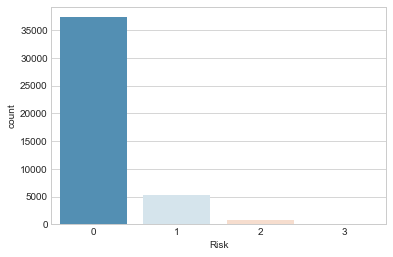

In [225]:
# view proportion of risk factor among population
sns.set_style('whitegrid')
sns.countplot(x='Risk',data=allDataClean,palette='RdBu_r')

In [226]:
# To increase balance of higher risk to lower risk, will group risk levels 1, 2, and 3 together as high risk and 0 as low risk:
allDataClean['Risk'] = allDataClean['Risk'].replace({0: 'low', 1: 'high', 2: 'high', 3: 'high'})

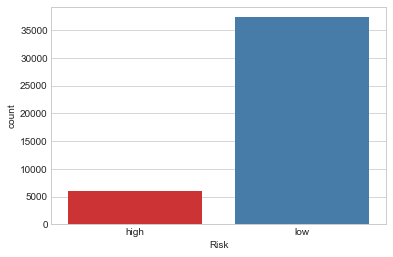

In [227]:
# Now, view new proportion of risk factor among population
sns.set_style('whitegrid')
sns.countplot(x='Risk',data=allDataClean,palette='Set1')

the dataset is still a bit unbalanced but is acceptable as higher risk for marjor cardio diseases  accounts for about 13% of the dataset.

In [228]:
allDataClean.groupby('Risk').count()

,Gender,Age,EverMarried,WorkType,ResidenceType,AvgGlucose,BMI
Risk,,,,,,,
high,6066,6066,6066,6066,6066,6066,6066
low,37334,37334,37334,37334,37334,37334,37334


#### Step4: Explore Data for Feature Selection

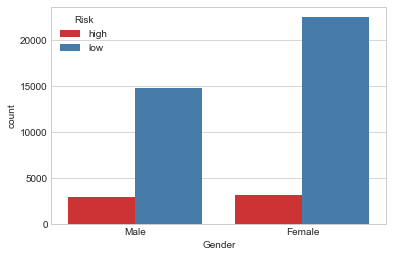

In [229]:
# 1) Look at Count of Risk by Gender (color = risk level)

# sns.countplot(x='Gender',hue='Risk',data=allDataClean,palette='Set1')
# sns.set_style('whitegrid')

# delete 'other' category in gender since it's under-represented
allDataClean = allDataClean[allDataClean.Gender != 'Other']
# view Count of Risk by Gender again (color = risk level)
sns.countplot(x='Gender',hue='Risk',data=allDataClean,palette='Set1')
sns.set_style('whitegrid')

In [230]:
# observe that still have over 40k rows after deleting other gender
allDataClean.shape

(43389, 8)

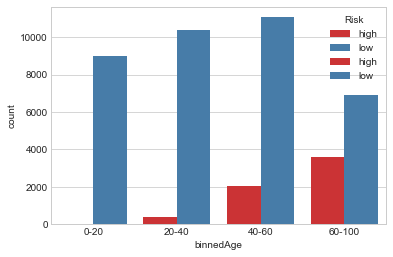

In [231]:
# 2) Look at Count of Risk by Age (color = risk level) 
sns.set_style('whitegrid')
ax = sns.countplot(x='Age',hue='Risk',data=allDataClean,palette='Set1')

# create more meaningful age groups
bins = [0, 20, 40, 60, 100]
labels = ['0-20', '20-40', '40-60', '60-100']
allDataClean['binnedAge'] = pd.cut(allDataClean['Age'], bins=bins, labels=labels)

# # view count of risk by new groups (color = risk)
sns.set_style('whitegrid')
ax = sns.countplot(x='binnedAge',hue='Risk',data=allDataClean,palette='Set1')

# drop old Age column
allDataClean = allDataClean.drop(['Age'], axis=1)

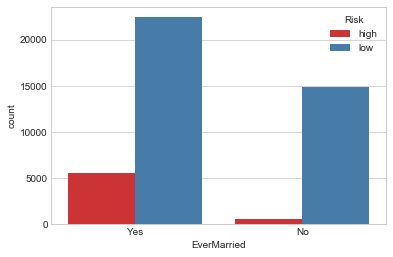

In [232]:
# 3) Look at Count of Risk by EverMarried (color = risk level) 
sns.set_style('whitegrid')
ax = sns.countplot(x='EverMarried',hue='Risk',data=allDataClean,palette='Set1')

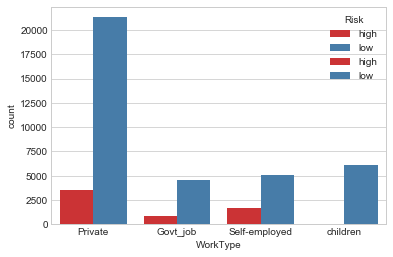

In [233]:
# 4) Look at Count of Risk by WorkType (color = risk level) 
sns.set_style('whitegrid')
ax = sns.countplot(x='WorkType',hue='Risk',data=allDataClean,palette='Set1')
# delete "Never_worked" category since under-represented
allDataClean = allDataClean[allDataClean.WorkType != 'Never_worked']
# view Count of Risk by Work Type again (color = risk level)
sns.countplot(x='WorkType',hue='Risk',data=allDataClean,palette='Set1')
sns.set_style('whitegrid')

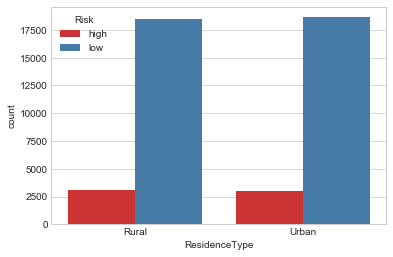

In [234]:
# 5) Look at Count of Risk by ResidenceType (color = risk level) 
sns.set_style('whitegrid')
ax = sns.countplot(x='ResidenceType',hue='Risk',data=allDataClean,palette='Set1')

In [236]:
# 6) Look at Count of Risk by Average Glucose (color = risk level) 

# sns.set_style('whitegrid')
# ax = sns.countplot(x='AvgGlucose',hue='Risk',data=allDataClean,palette='Set1')

allDataClean[allDataClean['Risk']=='low']['AvgGlucose'].hist(alpha=0.65,color='blue',
                                              bins=30,label='low risk')
allDataClean[allDataClean['Risk']=='high']['AvgGlucose'].hist(alpha=0.7,color='red',
                                              bins=30,label='high risk')
# plt.legend()
# plt.xlabel('AvgGlucose')

# create more meaningful Glucose groupings: "notHighAvgGlucose" = 0-150 and "highAvgGlucose" = 150-300
bins = [0, 150, 300]
labels = ['0-150', '150-300']
allDataClean['binnedAvgGlucose'] = pd.cut(allDataClean['AvgGlucose'], bins=bins, labels=labels)

# # view count of risk by new groups (color = risk)
sns.set_style('whitegrid')
ax = sns.countplot(x='binnedAvgGlucose',hue='Risk',data=allDataClean,palette='Set1')

# # drop old AvgGlucose column
allDataClean = allDataClean.drop(['AvgGlucose'], axis=1)

KeyError: 'AvgGlucose'

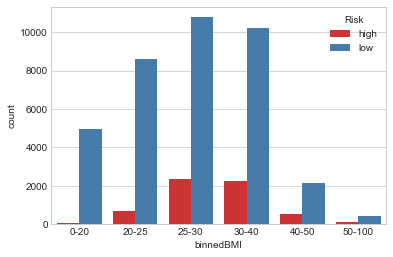

In [237]:
# 7) Look at Count of Risk by BMI (color = risk)
# sns.set_style('whitegrid')
# ax = sns.countplot(x='BMI',hue='Risk',data=allDataClean,palette='Set1')

# create more meaningful BMI groupings
bins = [0, 20, 25, 30, 40, 50, 100]
labels = ['0-20', '20-25', '25-30', '30-40', '40-50', '50-100']
allDataClean['binnedBMI'] = pd.cut(allDataClean['BMI'], bins=bins, labels=labels)

# # view count of risk by new groups (color = risk)
sns.set_style('whitegrid')
ax = sns.countplot(x='binnedBMI',hue='Risk',data=allDataClean,palette='Set1')

# drop old BMI column
allDataClean = allDataClean.drop(['BMI'], axis=1)

#### Based on Steps 1-4 we have an understanding of what the data looks like and what we would hypothesize to be the most important features to include. 

#### Next, we will build a decision tree and random forest in order to numerically observe the most important features.

#### Step5: Transform Categorical Features into Numeric

In [238]:
# view dataset information again
allDataClean.info() 
# observe that 4 variables are categorical 
# and need to be converted into meaningful numbers.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43212 entries, 0 to 43399
Data columns (total 8 columns):
Gender              43212 non-null object
EverMarried         43212 non-null object
WorkType            43212 non-null object
ResidenceType       43212 non-null object
Risk                43212 non-null object
binnedAge           43212 non-null category
binnedAvgGlucose    43212 non-null category
binnedBMI           43212 non-null category
dtypes: category(3), object(5)
memory usage: 3.4+ MB


In [239]:
# Convert categorical data to numbers using binary encoding 
# encode multiple columns using get_dummies (automatically detects if continuous)
allDataEncoded = allDataClean.copy()

# encode gender
genderFeatures = ['Gender']
allDataEncoded = pd.get_dummies(allDataClean,columns=genderFeatures,drop_first=True)

# then encode ever married
marriedFeatures = ['EverMarried']
allDataEncoded2 = pd.get_dummies(allDataEncoded,columns=marriedFeatures,drop_first=True)

# then encode work
workFeatures = ['WorkType']
allDataEncoded3 = pd.get_dummies(allDataEncoded2,columns=workFeatures,drop_first=True)

# then encode age
ageFeatures = ['binnedAge']
allDataEncoded4 = pd.get_dummies(allDataEncoded3,columns=ageFeatures,drop_first=True)

# # then encode glucose
glucoseFeatures = ['binnedAvgGlucose']
allDataEncoded5 = pd.get_dummies(allDataEncoded4,columns=glucoseFeatures,drop_first=True)

# # then encode bmi
bmiFeatures = ['binnedBMI']
allDataEncoded6 = pd.get_dummies(allDataEncoded5,columns=bmiFeatures,drop_first=True)

# encode risk
encodeRisk = ['Risk']
allDataEncoded8 = pd.get_dummies(allDataEncoded6,columns=encodeRisk,drop_first=True)

# encode res type
encodeRes = ['ResidenceType']
allDataEncoded7 = pd.get_dummies(allDataEncoded8,columns=encodeRes,drop_first=True)

allDataEncoded7.head()

,Gender_Male,EverMarried_Yes,WorkType_Private,WorkType_Self-employed,WorkType_children,binnedAge_20-40,binnedAge_40-60,binnedAge_60-100,binnedAvgGlucose_150-300,binnedBMI_20-25,binnedBMI_25-30,binnedBMI_30-40,binnedBMI_40-50,binnedBMI_50-100,Risk_low,ResidenceType_Urban
0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
4,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0


In [240]:
# observe descriptive statistics related to new dummy variables
allDataEncoded7.describe()

,Gender_Male,EverMarried_Yes,WorkType_Private,WorkType_Self-employed,WorkType_children,binnedAge_20-40,binnedAge_40-60,binnedAge_60-100,binnedAvgGlucose_150-300,binnedBMI_20-25,binnedBMI_25-30,binnedBMI_30-40,binnedBMI_40-50,binnedBMI_50-100,Risk_low,ResidenceType_Urban
count,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000
mean,0.408405,0.646256,0.574539,0.157202,0.142414,0.248079,0.303735,0.243219,0.129455,0.215311,0.303943,0.289133,0.061719,0.013330,0.859645,0.501203
std,0.491544,0.478137,0.494418,0.363995,0.349478,0.431903,0.459875,0.429031,0.335706,0.411042,0.459964,0.453365,0.240647,0.114683,0.347359,0.500004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Step6: Split data into training set and testing set

In [241]:
from sklearn.model_selection import train_test_split

In [242]:
X = allDataEncoded7.drop('Risk_low',axis=1)
y = allDataEncoded7['Risk_low']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=71, stratify=y)

In [243]:
# normalize
sds = StandardScaler()
sds.fit(X_train)
X_train = sds.transform(X_train)
X_test = sds.transform(X_test)

C:\Users\Cnellis\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  """


#### Step 7: train a decision tree model

In [244]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data.
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Step 8: predict and evaluate decision tree 

In [245]:
# create predictions from the test set
predictions = dtree.predict(X_test)

In [246]:
# create a classification report and a coonfusion matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.44      0.10      0.16      1516
           1       0.87      0.98      0.92      9287

   micro avg       0.86      0.86      0.86     10803
   macro avg       0.65      0.54      0.54     10803
weighted avg       0.81      0.86      0.81     10803



In [247]:
print(confusion_matrix(y_test,predictions))

[[ 145 1371]
 [ 184 9103]]


In [248]:
print(f"Training Data Score: {dtree.score(X_train, y_train)}")
print(f"Testing Data Score: {dtree.score(X_test, y_test)}")

Training Data Score: 0.8641118207905212
Testing Data Score: 0.8560585022678886


In [249]:
import os
import time
import sys

# use decision tree to consider feature importance
# for i in range(3):
    
#     t0 = time.time()
#     clf = DecisionTreeClassifier()
    
#     clf.fit(X_train, y_train)
#     t1 = time.time()
    
#     ypred = clf.predict(X_test)
#     scores = roc_auc_score(y_test, ypred)
    
#     print(f"Decision tree {i+1} took {t1-t0} seconds to train and got a score of {scores}")
#     print()
#     print("And here are the top features: ")
#     c = X.columns 
#     for cfi in zip(c, clf.feature_importances_):
#         print(cfi)
#     print()

#### Step 9: Train a random forest model to evaluate potential features

In [250]:
# create an instance of the random forest classifer class 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
rfc.score(X_train,y_train)

# create and sort feature importance
importances = rfc.feature_importances_
feature_importances = pd.DataFrame(rfc.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

                          importance
binnedAge_60-100            0.320564
binnedAvgGlucose_150-300    0.152601
EverMarried_Yes             0.106218
binnedAge_20-40             0.082675
binnedAge_40-60             0.060984
Gender_Male                 0.048310
WorkType_Self-employed      0.040155
ResidenceType_Urban         0.038387
WorkType_children           0.034663
WorkType_Private            0.029390
binnedBMI_20-25             0.023123
binnedBMI_25-30             0.017629
binnedBMI_30-40             0.017448
binnedBMI_40-50             0.016973
binnedBMI_50-100            0.010881


#### Based on Steps 5-10, we can conclude that :

#### Glucose, BMI, and Age appear are most useful in predicting cardiovascular risk,

#### Marriage Status, residence type, and gender add some value, 

#### and work type is the least effective feature in cardiovascular risk prediction.


####  Decide to keep only AvgGlucose, BMI, Age, Marriage Status, Residence Type, and Gender
#### Step11: View relationships 

Reference: https://github.com/xr71/uncc-titanic-ml-inclass-demo/blob/master/titaniclearn.ipynb

In [256]:
# look at univariate relationships

In [257]:
# look at multi-variate relationships

In [ ]:
# look at relationship between avgGlucose and risk
# sns.regplot(x="AvgGlucose", y="Risk_low", data=allDataEncoded7, fit_reg=False, y_jitter=0.1)

# look at relationship between BMI and risk
# sns.regplot(x="BMI", y="Risk_low", data=allDataEncoded7, fit_reg=False, y_jitter=0.1)

# look at relationship between age and risk
# sns.regplot(x="Age", y="Risk_low", data=allDataEncoded7, fit_reg=False, y_jitter=0.1)

# look at relationship between everMarried and risk
# sns.regplot(x="EverMarried_Yes", y="Risk_low", data=allDataEncoded7, fit_reg=False, y_jitter=0.1)

# look at relationship between ResidenceType_Urban and risk
# sns.regplot(x="ResidenceType_Urban", y="Risk_low", data=allDataEncoded7, fit_reg=False, y_jitter=0.1)

# look at relationship between gender and risk
# sns.regplot(x="Gender_Male", y="Risk_low", data=allDataEncoded7, fit_reg=False, y_jitter=0.1)

In [ ]:
sns.violinplot(x="Gender_Male", y="Risk_low", data=allDataEncoded7)

In [251]:
# Principal component analysis (PCA) provides dimensionality reduction. 

In [252]:
#########################################

In [253]:
# Logistic Regression = used for binary classification

In [254]:
# Random Forest is an ensemble of decision trees.

In [255]:
# SVC
# Support Vector Machines